# Chirp tone generator on IQ modulation

In [1]:
%matplotlib inline

from numpy import zeros, append, linspace, cos, pi, int16, log10
from scipy.io.wavfile import write
from scipy.signal import spectrogram
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
from IPython.display import display, Audio

In [2]:
SAMPLING_RATE = 44100  # Hz
TIME_FRAME = 0.0205 # Time frame in sec
AMPLITUDE = 20000 # 16bit PCM max amplitude

# Chirp bandwidth in Hz
BW = 3000 

# Carrier in Hz
CARRIER=18000

WAVE_FILE="./ChirpTone.wav"

In [3]:
F0 = -BW/2
F1 = +BW/2

## Chirp tone synsthesis

In [4]:
# Real version of chirp tone generator
def chirp_iq(f0=F0, f1=F1, fc=CARRIER, amp=AMPLITUDE, updown="up", T=TIME_FRAME, phase=-pi/2.0):
    t = linspace(0, T, int(T * SAMPLING_RATE))
    k = float(f1 - f0)/float(T)
    if (updown == "up"):
        fb = f0 + k * t / 2.0
    elif (updown == "down"):
        fb = f1 - k * t / 2.0
    arg = (2.0 * pi * (fc + fb) * t) + phase
    return cos(arg) * amp

## Utility

In [5]:
# Plot FFT frequency domain
def plot_fft(wave, thres=0.95, logscale=False):
    plt.figure(figsize=(8, 4), dpi=80)
    y = fftshift(fft(wave))
    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

    a = abs(y)
    if logscale:
        plt.plot(freq, 10 * log10(a))
        plt.ylabel("Magnitude(dB)")
    else:
        plt.plot(freq, a)
        plt.ylabel("Magnitude")
    plt.xlabel("Frequency(Hz)")
    plt.title("Frequency domain")

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))
    print("Frequencies at peaks: {} Hz".format(freq[peakutils.indexes(a, thres=thres)]))

Frequencies at peaks: [-19171.7920354  -16830.19911504  16830.19911504  19171.7920354 ] Hz
Frequencies at peaks: [-19171.7920354  -16830.19911504  16830.19911504  19171.7920354 ] Hz


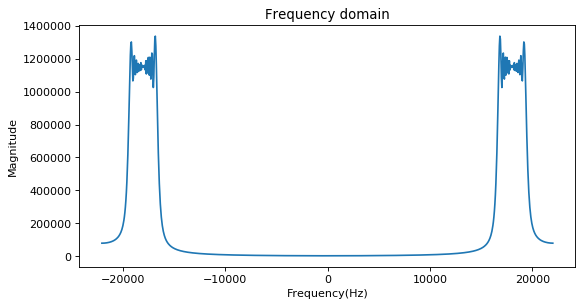

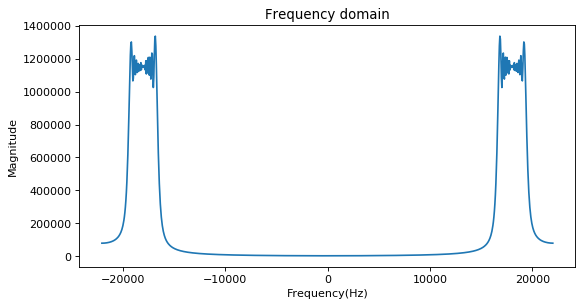

In [6]:
UP = chirp_iq()
DOWN = chirp_iq(updown='down')
plot_fft(UP)
plot_fft(DOWN)

In [7]:
tone = UP
for i in range(99):
    tone = append(tone, UP)

WAVE_FILE="./ChirpTone.wav"
write(WAVE_FILE, SAMPLING_RATE, tone.astype(int16))
display(Audio('./' + WAVE_FILE))